In [1]:
import sys
import logging
import boto3
from datetime import datetime
from datetime import datetime, timedelta
import math
import random
import numpy as np
import json

from datetime import datetime
import boto3
import json
import pandas as pd
from datetime import datetime, timedelta
import boto3
import warnings
import pandas as pd
import time
import traceback
import warnings
import decimal
from decimal import Decimal
import json

import re
##libraries required
import math
import re
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy
import csv
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import pandas as pd
from pathlib import Path
from tokenizers.trainers import BpeTrainer,WordPieceTrainer
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder,WordPiece as WordPieceDecoder
from tokenizers.models import BPE,WordPiece
from tokenizers.normalizers import Lowercase, NFKC, Sequence
from tokenizers.pre_tokenizers import BertPreTokenizer


In [2]:
pd.read_csv('item-tags-sg-9may.csv').head()

,country_id,name,department_name,sub_department_name
0,4.0,Mysore Sandal Powder,Personal Care,Feminine Care
1,4.0,Life Alkaline Bottle Water pH 8.5 510ml,Beverages,Water
2,4.0,Ben & Jerry Choc Fud Brownie 458ml [68030002],Ice Cream & Dessert,Ice Cream
3,4.0,NN016 BoBo Cooked Fishball 250g (26 pcs) I 250 g,Eid al-Fitr,Chilled/Frozen
4,4.0,"2 x Tullamore D.E.W. Original, 700ml","Wine, Beers & Spirits",Spirits


# TRAIN TOKENIZER

In [3]:


# First we create an empty Byte-Pair Encoding model (i.e. not trained model)
tokenizer = Tokenizer(WordPiece())

# Then we enable lower-casing and unicode-normalization
# The Sequence normalizer allows us to combine multiple Normalizer that will be
# executed in order.
tokenizer.normalizer = Sequence([
    NFKC(),
    Lowercase()
])

# Our tokenizer also needs a pre-tokenizer responsible for converting the input to a ByteLevel representation.
tokenizer.pre_tokenizer = BertPreTokenizer()

# And finally, let's plug a decoder so we can recover from a tokenized input to the original one
tokenizer.decoder = WordPieceDecoder()


paths = [str(x) for x in Path(".").glob("item-tags-sg-9may.csv")]



In [4]:


# We initialize our trainer, giving him the details about the vocabulary we want to generate
trainer = WordPieceTrainer(vocab_size=30522, show_progress=True,special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],wordpieces_prefix="##")
tokenizer.train(files=paths, trainer=trainer)

print("Trained vocab size: {}".format(tokenizer.get_vocab_size()))

Trained vocab size: 14479


In [5]:
encoding = tokenizer.encode("NN016 BoBo Cooked Fishball 250g")
encoding.tokens

['nn016', 'bobo', 'cooked', 'fishball', '250g']

In [57]:
!mkdir ItemTaggingMultiLingualWordPiece

mkdir: ItemTaggingMultiLingualWordPiece: File exists


In [6]:
tokenizer.model.save("ItemTaggingMultiLingualWordPiece")

['ItemTaggingMultiLingualWordPiece/vocab.txt']

In [59]:
!ls ItemTaggingMultiLingualWordPiece

vocab.txt


# Load Tokenizer

In [7]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("./ItemTaggingMultiLingualWordPiece", max_len=512)

In [9]:
(tokenizer.encode_plus('mysore sandal')).tokens

<bound method BatchEncoding.tokens of {'input_ids': [2, 7156, 4003, 3], 'attention_mask': [1, 1, 1, 1]}>

In [10]:
from transformers import DistilBertConfig

config = DistilBertConfig(
    vocab_size=52_000,
    max_position_embeddings=512,
    n_heads=12,
    n_layers=6
)

In [11]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("./ItemTaggingMultiLingualWordPiece/")

In [12]:
from transformers import TFDistilBertModel,DistilBertModel,DistilBertTokenizerFast, TFDistilBertMainLayer
#model_name = 'distilbert-base-multilingual-cased'
# Max length of tokens
max_length = 20

tokenizer = DistilBertTokenizerFast.from_pretrained("./ItemTaggingMultiLingualWordPiece",  max_len=512)
# Load the Transformers BERT model
#transformer_model = TFDistilBertModel.from_pretrained(model_name, config = config)


#transformer_model = TFXLMRobertaModel.from_pretrained(model_name, config = config)
transformer_model = DistilBertModel(config=config)

# TRAIN DISTIL BERT MODEL

In [13]:
from transformers import DistilBertForMaskedLM, TFDistilBertForMaskedLM

model = DistilBertForMaskedLM(config=config)


#model = TFRobertaForMaskedLM(config=config)

In [15]:
# CREATE SAMPLE DATA FILE
f= open('item-tags-sg-9may.csv' , 'r')
wf = open('mulilingual_data.txt','w')
i = 0
while i < 1000:
    line = f.readline()
    wf.write(line)
    i = i +1
wf.close()
f.close()


In [17]:
!cat mulilingual_data.txt

country_id,name,department_name,sub_department_name
4,Mysore Sandal Powder,Personal Care,Feminine Care
4,Life Alkaline Bottle Water pH 8.5 510ml,Beverages,Water
4,Ben & Jerry  Choc Fud Brownie 458ml [68030002],Ice Cream & Dessert,Ice Cream
4,NN016 BoBo Cooked Fishball 250g (26 pcs) I 250 g,Eid al-Fitr,Chilled/Frozen
4,"2 x Tullamore D.E.W. Original, 700ml","Wine, Beers & Spirits",Spirits
4,Muffin Breakfast Set,Cakes & Bakes,Muffins
4,Coconut EZ Mini Crunchies 60G 椰子小松脆 60g,Instant Food,Ready Meals
4,OKAMOTOÂ® Crown Latex Condoms 12s 22581,Health & Wellness,Sexual Wellness
4,WATSONS 3D Face Mask for Adults Black 3s 49773,Health & Wellness,Medical Supplies
4,BANANA BOAT Sport Sunscreen Lotion SPF110 UVB PA+++ 90ml 54200,Beauty & Skincare,Suncare
4,WATSONS Soft & Clean Round Facial Cotton Puffs 100s 88708,Household Goods,Tissue & Paper
4,Carlsberg Can Beer - Green Label 500ml,"Wine, Beers & Spirits",Beer
4,Melanzane Pasta Sauce,Cooking & Condiments,Essential Cooking Supplies
4,YOU-C1000 I

In [18]:
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="mulilingual_data.txt",
    #file_path="test.txt",
    block_size=128,
)

In [19]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./MLModelDistil",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=5,
    save_steps=10_000,
    save_total_limit=2,
    #prediction_loss_only=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

In [21]:
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


KeyboardInterrupt: 

In [22]:
trainer.save_model("./MLModelDistil")

In [23]:
import transformers

In [24]:
bert_ = transformers.TFDistilBertModel.from_pretrained( './MLModelDistil/', from_pt=True )

All PyTorch model weights were used when initializing TFDistilBertModel.

Some weights or buffers of the PyTorch model TFDistilBertModel were not initialized from the TF 2.0 model and are newly initialized: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
bert_.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  82857984  
Total params: 82,857,984
Trainable params: 82,857,984
Non-trainable params: 0
_________________________________________________________________


In [25]:

max_length = 20

import transformers
from transformers import DistilBertForMaskedLM,TFDistilBertModel,DistilBertModel

#transformer_model = TFXLMRobertaModel.from_pretrained(model_name, config = config)
#transformer_model = TFRobertaModel(config=config)

transformer_model = transformers.TFDistilBertModel.from_pretrained( './MLModelDistil/', from_pt=True )

All PyTorch model weights were used when initializing TFDistilBertModel.

Some weights or buffers of the PyTorch model TFDistilBertModel were not initialized from the TF 2.0 model and are newly initialized: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# DATA READ

In [13]:
pdf = pd.read_csv('../trainingdata/item-tags-ind-combined.csv')

In [14]:
#pdf= pdf[:1000]

In [15]:
pdf.count()

name                   316654
department_name        316654
sub_department_name    316654
dtype: int64

In [16]:
pdf = pdf.dropna()

In [17]:
pdf = pdf.drop_duplicates()

In [18]:
pdf['department_name'].value_counts()

Personal Care & Beauty    40004
Frozen                    38877
Staples & Pantry          34423
Snacks                    28670
Beverages                 25416
Home Care                 18734
Health & Wellness         16303
Others                    14994
Fresh Produce             14528
Baby Needs                13167
Meat & Seafood            13002
Dairy & Eggs              11226
Noodles & Instant Food     9105
Meal Kits                  8057
Cakes & Dessert            7705
Books & Stationeries       4751
Pets                       4232
Bakery                     3447
Handphone & Tablet         2427
Electronics                1745
Breakfast                  1367
Fashion                    1020
Automotive                  995
Tobacco                     856
Baby & Kids                 765
Toys & Games                276
Gifts & Party               234
Festive Special             225
Gardening                    98
Sports                        5
Name: department_name, dtype: int64

In [19]:
pdf['department_name'].value_counts()

Personal Care & Beauty    40004
Frozen                    38877
Staples & Pantry          34423
Snacks                    28670
Beverages                 25416
Home Care                 18734
Health & Wellness         16303
Others                    14994
Fresh Produce             14528
Baby Needs                13167
Meat & Seafood            13002
Dairy & Eggs              11226
Noodles & Instant Food     9105
Meal Kits                  8057
Cakes & Dessert            7705
Books & Stationeries       4751
Pets                       4232
Bakery                     3447
Handphone & Tablet         2427
Electronics                1745
Breakfast                  1367
Fashion                    1020
Automotive                  995
Tobacco                     856
Baby & Kids                 765
Toys & Games                276
Gifts & Party               234
Festive Special             225
Gardening                    98
Sports                        5
Name: department_name, dtype: int64

In [20]:
pdf['sub_department_name'].value_counts()

Frozen Produce            28274
Other Needs               14994
Bath & Shower             12850
Chips & Crackers          10207
Biscuits & Cookies         9782
                          ...  
Sport Equipments              5
Cooking Books                 4
pasta                         2
Adult's Health Product        2
Cards                         2
Name: sub_department_name, Length: 135, dtype: int64

In [21]:
pdf.count()

name                   316654
department_name        316654
sub_department_name    316654
dtype: int64

In [22]:
pd.options.display.max_rows = 999

In [23]:
pdf = pdf[pdf['sub_department_name'].map(pdf['sub_department_name'].value_counts()) > 2]


# Data Preprocessing

In [24]:
maxlen = 0
maxword = ''
sentences = []
for line in list(pdf['name'].values):
    #print(line.rstrip())
    words = []
    #print(line)
    val = str(line).rstrip().lower()
    words = val.split(' ')
    newval = ''
    for i in words:
        i = i.replace('(','').replace(')','').replace('/','').replace(',','').replace('.','').replace('+','').replace('\'','').replace(' ','')
        i = "".join(filter(lambda x: not x.isdigit(), i))
        newval = newval + i + ' '
        updatedString = newval[0:len(newval) -1 ]
    #val = re.sub('\W+','', val )
    #newwords = []
    #newwords.append(updatedString)
    sentences.append(updatedString)

In [25]:
sentences[0]

'minyak goreng kemasan sofia'

In [26]:
pdf['name'] = sentences

In [27]:
pdf.tail(100)

,name,department_name,sub_department_name
316554,yummy ybrc bites flavour carrot g,Baby & Kids,Food & Formula
316555,yummy ybrc bites flavor apple g,Baby & Kids,Food & Formula
316556,yummy ybrc bites flavor banana g,Baby & Kids,Food & Formula
316557,yummy ybrc bites flavor strawberry g,Baby & Kids,Food & Formula
316558,yunyi tahu kuning s,Fresh Produce,Tofu/Meat Alternatives
316559,yunyi tahu putih s,Fresh Produce,Tofu/Meat Alternatives
316560,yunyie kings kuning s,Fresh Produce,Tofu/Meat Alternatives
316561,yunyie kings putih s,Fresh Produce,Tofu/Meat Alternatives
316562,yupi gummi pizza gr,Snacks,Chocolates & Candies
316563,yuri aganol lavender ml,Home Care,Other Home Care


# DISTIL BERT MULTILABEL CLASSIFICATION

In [28]:
from transformers import TFBertModel , TFDistilBertModel,  DistilBertConfig, DistilBertTokenizer
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalMaxPool1D, Concatenate
#from transformers import TFDistilBertMainLayer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,Precision,Recall
from tensorflow.keras.utils import to_categorical
# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split

In [29]:
data = pdf
data.head()

,name,department_name,sub_department_name
0,minyak goreng kemasan sofia,Staples & Pantry,Oils & Vinegars
1,sosis ayam premio g,Frozen,Frozen Meals
2,kentang barts kg,Frozen,Frozen Meals
3,glow cream,Personal Care & Beauty,Make-up & Accessories
4,ng-bdsap,Personal Care & Beauty,Skin & Hair Care


In [30]:
data['department_name'] = pd.Categorical(data['department_name'])
data['sub_department_name'] = pd.Categorical(data['sub_department_name'])

In [31]:
department_name_dict = dict( enumerate(data['department_name'].cat.categories ) )

In [32]:
department_name_dict

{0: 'Automotive',
 1: 'Baby & Kids',
 2: 'Baby Needs',
 3: 'Bakery',
 4: 'Beverages',
 5: 'Books & Stationeries',
 6: 'Breakfast',
 7: 'Cakes & Dessert',
 8: 'Dairy & Eggs',
 9: 'Electronics',
 10: 'Fashion',
 11: 'Festive Special',
 12: 'Fresh Produce',
 13: 'Frozen',
 14: 'Gardening',
 15: 'Gifts & Party',
 16: 'Handphone & Tablet',
 17: 'Health & Wellness',
 18: 'Home Care',
 19: 'Meal Kits',
 20: 'Meat & Seafood',
 21: 'Noodles & Instant Food',
 22: 'Others',
 23: 'Personal Care & Beauty',
 24: 'Pets',
 25: 'Snacks',
 26: 'Sports',
 27: 'Staples & Pantry',
 28: 'Tobacco',
 29: 'Toys & Games'}

In [33]:
sub_department_name_dict = dict( enumerate(data['sub_department_name'].cat.categories ) )

In [34]:
sub_department_name_dict

{0: '-',
 1: 'Baby & Kids Fashion',
 2: 'Baby Equipment',
 3: 'Bags',
 4: 'Baking',
 5: 'Bath & Body Care',
 6: 'Bath & Shower',
 7: 'Bath & body care',
 8: 'Beer',
 9: 'Bird Food & Care',
 10: 'Biscuits & Cookies',
 11: 'Biscuits & Hampers',
 12: 'Biscuits & cookies',
 13: 'Breads',
 14: 'Buns & Rolls',
 15: 'Cakes & Pastries',
 16: 'Canned Goods',
 17: 'Car Accessories',
 18: 'Cat Food & Care',
 19: 'Cereal',
 20: 'Cheese, Cream & Butter',
 21: 'Children Books',
 22: 'Children Toys',
 23: 'Chips & Crackers',
 24: 'Chips & crackers',
 25: 'Chocolate & Drink Mixes',
 26: 'Chocolates & Candies',
 27: 'Cigarettes',
 28: 'Coffee Instant Mix',
 29: 'Coffee Ready Drink',
 30: 'Computer Accessories',
 31: 'Condensed Milk',
 32: 'Cooking Books',
 33: 'Diapers & Wipes',
 34: 'Dish Cleaning',
 35: 'Dish cleaning',
 36: 'Dog Food & Care',
 37: 'Donuts',
 38: 'Dry Cakes',
 39: 'Eggs',
 40: 'Energy Bars',
 41: 'Energy Drinks',
 42: 'Feminine Care',
 43: 'First Aid & Health Care',
 44: 'Fish Food &

In [35]:

# Transform your output to numeric
data['department_name'] = data['department_name'].cat.codes
data['sub_department_name'] = data['sub_department_name'].cat.codes


In [36]:
data.head()

,name,department_name,sub_department_name
0,minyak goreng kemasan sofia,27,81
1,sosis ayam premio g,13,49
2,kentang barts kg,13,49
3,glow cream,23,71
4,ng-bdsap,23,108


In [37]:

# Split into train and test - stratify over Issue
data_train, data_test = train_test_split(data, test_size = 0.1, stratify=data['sub_department_name'], random_state=66)

In [38]:
len(data_train)

284983

In [39]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [40]:
len(data_train.department_name.value_counts())

30

In [41]:
# Load the model

max_length = 20

import transformers
from transformers import DistilBertForMaskedLM,TFDistilBertModel,DistilBertModel

#transformer_model = TFXLMRobertaModel.from_pretrained(model_name, config = config)
#transformer_model = TFRobertaModel(config=config)

transformer_model = transformers.TFDistilBertModel.from_pretrained( './MLModelDistilInd/', from_pt=True )


All PyTorch model weights were used when initializing TFDistilBertModel.

Some weights or buffers of the PyTorch model TFDistilBertModel were not initialized from the TF 2.0 model and are newly initialized: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Load the MainLayer
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[0]

X = GlobalMaxPool1D()(bert_model)

dropout = Dropout(0.2, name='pooled_output')
pooled_output = dropout(X, training=False)

# Then build your model output
department_name = Dense(units=len(data.department_name.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='department_name')(pooled_output)

department_name_dense = Dense(units=796, activation = 'relu', name='department_name_dense')(department_name)


merged = Concatenate()([pooled_output, department_name_dense])

sub_department_name = Dense(units=len(data.sub_department_name.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='sub_department_name')(merged)

outputs = {'department_name': department_name, 'sub_department_name': sub_department_name}
# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay ((None, 20, 768),)   82857984    input_ids[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           distilbert[0][0]                 
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           global_max_pooling1d[0][0]       
_________________________________________________________________________

In [43]:
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = {'department_name': CategoricalCrossentropy(from_logits = True), 'sub_department_name': CategoricalCrossentropy(from_logits = True)}
metric = {'department_name': [CategoricalAccuracy('accuracy')], 'sub_department_name': [CategoricalAccuracy('accuracy')]}
#metric = {'department_name': [Recall()], 'sub_department_name': [CategoricalAccuracy('accuracy')]}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [44]:
# Ready output data for the model
y_department_name = to_categorical(data_train['department_name'])
y_sub_department_name = to_categorical(data_train['sub_department_name'])
# Tokenize the input (takes some time)

In [45]:
y_sub_department_name.shape

(284983, 132)

In [46]:
y_department_name.shape

(284983, 30)

In [47]:

x = tokenizer(
    text=data_train['name'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False, 
    verbose=True)

In [48]:
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'department_name': y_department_name, 'sub_department_name': y_sub_department_name},
    validation_split=0.2,
    batch_size=64,
    epochs=10)

Train on 227986 samples, validate on 56997 samples
Epoch 1/10
227986/227986 [==============================] - 1130s 5ms/sample - loss: 2.3214 - department_name_loss: 0.8360 - sub_department_name_loss: 1.4854 - department_name_accuracy: 0.7671 - sub_department_name_accuracy: 0.6501 - val_loss: 1.9467 - val_department_name_loss: 0.7141 - val_sub_department_name_loss: 1.2326 - val_department_name_accuracy: 0.8005 - val_sub_department_name_accuracy: 0.6959
Epoch 2/10
227986/227986 [==============================] - 1114s 5ms/sample - loss: 1.9102 - department_name_loss: 0.6974 - sub_department_name_loss: 1.2128 - department_name_accuracy: 0.8023 - sub_department_name_accuracy: 0.6998 - val_loss: 1.8663 - val_department_name_loss: 0.6872 - val_sub_department_name_loss: 1.1791 - val_department_name_accuracy: 0.8071 - val_sub_department_name_accuracy: 0.7070
Epoch 3/10
227986/227986 [==============================] - 1115s 5ms/sample - loss: 1.8422 - department_name_loss: 0.6732 - sub_depart

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



227986/227986 [==============================] - 1115s 5ms/sample - loss: 1.7477 - department_name_loss: 0.6391 - sub_department_name_loss: 1.1085 - department_name_accuracy: 0.8174 - sub_department_name_accuracy: 0.7190 - val_loss: 1.7705 - val_department_name_loss: 0.6543 - val_sub_department_name_loss: 1.1162 - val_department_name_accuracy: 0.8159 - val_sub_department_name_accuracy: 0.7192
Epoch 8/10
227986/227986 [==============================] - 1115s 5ms/sample - loss: 1.7368 - department_name_loss: 0.6351 - sub_department_name_loss: 1.1016 - department_name_accuracy: 0.8182 - sub_department_name_accuracy: 0.7205 - val_loss: 1.7627 - val_department_name_loss: 0.6515 - val_sub_department_name_loss: 1.1111 - val_department_name_accuracy: 0.8171 - val_sub_department_name_accuracy: 0.7206
Epoch 9/10
227986/227986 [==============================] - 1114s 5ms/sample - loss: 1.7249 - department_name_loss: 0.6308 - sub_department_name_loss: 1.0943 - department_name_accuracy: 0.8197 - su

In [49]:
history.history

{'loss': [2.321362367153657,
  1.9101857711970724,
  1.8421775955024575,
  1.8051020672985314,
  1.779513715404088,
  1.7620205627497056,
  1.7476528313543256,
  1.7367541476803503,
  1.7249451258845265,
  1.7177732247893325],
 'department_name_loss': [0.8359759,
  0.697364,
  0.6732277,
  0.6596497,
  0.65041673,
  0.6445241,
  0.6390735,
  0.63505965,
  0.630772,
  0.6283542],
 'sub_department_name_loss': [1.4853857,
  1.2127821,
  1.1690134,
  1.1453528,
  1.1289089,
  1.1175603,
  1.108489,
  1.1015862,
  1.0942839,
  1.0894471],
 'department_name_accuracy': [0.76706463,
  0.80233437,
  0.8087997,
  0.8114665,
  0.8140938,
  0.8160808,
  0.8174098,
  0.8181643,
  0.8197082,
  0.820296],
 'sub_department_name_accuracy': [0.650132,
  0.6997886,
  0.70781976,
  0.7120481,
  0.7154299,
  0.71784234,
  0.7189564,
  0.7205486,
  0.72210133,
  0.7236102],
 'val_loss': [1.946671785533513,
  1.8663371178715544,
  1.8315076787867024,
  1.8082671098391867,
  1.7926701814318455,
  1.7796766556

In [50]:
import matplotlib.pyplot as plt
def printGraph(history):
    
    plt.plot(history.history['department_name_accuracy'])
    plt.plot(history.history['val_department_name_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('department_name_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

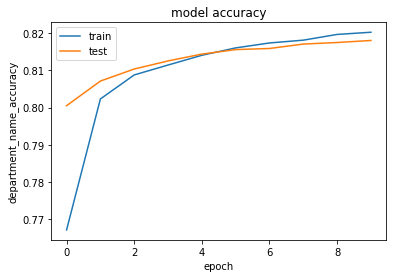

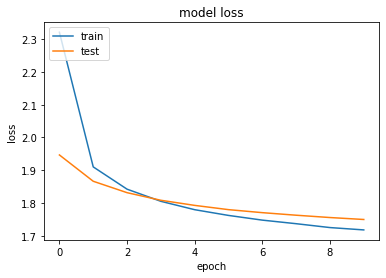

In [51]:
# Print Historical accuracy and Loss
printGraph(history)

In [58]:
model.save('v3-distil-concat-item-embedding.h5')


In [59]:
# Test Output
import tensorflow as tf
model = tf.keras.models.load_model('v3-distil-concat-item-embedding.h5')



ValueError: Unknown layer: TFDistilBertMainLayer

In [60]:
print(tf.__version__)

2.0.0


In [ ]:
test_y_department_name = to_categorical(data_test['department_name'])
test_y_sub_department_name = to_categorical(data_test['sub_department_name'])
test_x = tokenizer(
    text=data_test['name'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'department_name': test_y_department_name, 'sub_department_name': test_y_sub_department_name}
)

# Test Sample Data 

In [ ]:
# Test Output
import tensorflow as tf
from transformers import TFDistilBertModel,  DistilBertConfig, DistilBertTokenizer
model = tf.keras.models.load_model('v2-distil-concat-item-embedding.h5')

In [ ]:
# Load BERT tokenizer
model_name = 'distilbert-base-multilingual-cased'
# Max length of tokens
max_length = 20
# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

In [ ]:
sentence = ['Sosis Ayam Premio 500G']
#sentence = ['Minyak Goreng Kemasan Sofia']
#sentence = ['Pot Bunga Putih Polos No.2']
#sentence = ['Bilberry 50 Kapsul eaeq eewe']
sentence = ['Kentang 3 Kg']

In [ ]:
test_x = tokenizer(
    text=sentence,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [ ]:
output = model.predict(x={'input_ids': test_x['input_ids']})

In [ ]:
import numpy as np
department_name_dict[np.argmax(output['department_name'])]

In [ ]:
sub_department_name_dict[np.argmax(output['sub_department_name'])]

# VALIDATE MODEL

In [ ]:
# Test Output
import tensorflow as tf
model = tf.keras.models.load_model('v2-distil-concat-item-embedding.h5')


In [ ]:
test_y_department_name = to_categorical(data_test['department_name'])
test_y_sub_department_name = to_categorical(data_test['sub_department_name'])
test_x = tokenizer(
    text=data_test['name'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)



In [ ]:
output = model.predict(x={'input_ids': test_x['input_ids']})

In [ ]:
department_names = output['department_name']
sub_department_names = output['sub_department_name']

In [ ]:

department_name_prediction=[]
department_name_actual = []

sub_department_name_prediction=[]
sub_department_name_actual = []
for i in range(0,len(department_names)):
    department_name_prediction.append(department_name_dict[np.argmax(department_names[i])])
    department_name_actual.append(department_name_dict[data_test['department_name'].values[i]])
for i in range(0,len(sub_department_names)):
    sub_department_name_prediction.append(sub_department_name_dict[np.argmax(sub_department_names[i])])
    sub_department_name_actual.append(sub_department_name_dict[data_test['sub_department_name'].values[i]])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(department_name_actual, department_name_prediction))

In [ ]:
print(classification_report(sub_department_name_actual, sub_department_name_prediction))

In [ ]:
data_test_evaluate = pd.DataFrame()
data_test_evaluate['name'] = data_test['name']
data_test_evaluate['department_name_actual'] = department_name_actual

data_test_evaluate['department_name_prediction'] = department_name_prediction
data_test_evaluate['sub_department_name_actual'] = sub_department_name_actual

data_test_evaluate['sub_department_name_prediction'] = sub_department_name_prediction

In [ ]:
data_test_evaluate

In [ ]:
data_test_evaluate[(data_test_evaluate['sub_department_name_actual'] == 'Frozen Meat & Seafood') & (data_test_evaluate['sub_department_name_prediction'] != 'Frozen Meat & Seafood') ]